In [1]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [2]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2 import robjects
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
robjects.r('''
    suppressPackageStartupMessages({
        library(reticulate)
        library(ggplot2)
        library(tidyr)
        library(dplyr)
        library(purrr)
        library(tibble)
    })
    library("nichenetr", lib="/home/d/danilina/mambaforge/envs/scanpy_r/lib/R/library")
''')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [4]:
adata = sc.read("/home/d/danilina/masterprak/data/for_merge/Peyser_Merging.h5ad")
adata

AnnData object with n_obs × n_vars = 18686 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'

In [5]:
adata.obs

,batch,condition,manual_celltype_annotation
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,saline,Interstitial Macrophage
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,saline,B-cells
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,saline,Lymphatic endothelial
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,saline,Alveolar macrophages
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,saline,Endothelial
...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,nintedanib,Classical monocytes
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,nintedanib,B-cells


In [6]:
list(adata.obs["condition"].cat.categories)

['bleomycin', 'nintedanib', 'saline']

In [7]:
condition = [x for x in ['bleomycin', 'bleo', 'Bleo', 'asbestos'] if x in list(adata.obs["condition"].cat.categories)][0]
control = [x for x in ['saline', 'healthy', 'UT', 'control'] if x in list(adata.obs["condition"].cat.categories)][0]

In [8]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [9]:
adata.obs.batch

AAACCTGAGGAATTAC-1        GSM3716976_saline.947170
AAACCTGCATAACCTG-1        GSM3716976_saline.947170
AAACCTGCATTGGGCC-1        GSM3716976_saline.947170
AAACCTGGTCTCAACA-1        GSM3716976_saline.947170
AAACCTGGTTGACGTT-1        GSM3716976_saline.947170
                                  ...             
TTTGCGCCAGACAAGC-1    GSM3716985_nintedanib.947178
TTTGCGCGTCATATGC-1    GSM3716985_nintedanib.947178
TTTGCGCGTCCGAATT-1    GSM3716985_nintedanib.947178
TTTGGTTGTAGCTTGT-1    GSM3716985_nintedanib.947178
TTTGGTTTCATCGATG-1    GSM3716985_nintedanib.947178
Name: batch, Length: 18686, dtype: category
Categories (11, object): ['GSM3716976_saline.947170', 'GSM3716982_bleomycin.947176', 'GSM3716980_bleomycin.947173', 'GSM3716978_saline.955736', ..., 'GSM3716986_nintedanib.947179', 'GSM3716979_saline.955737', 'GSM3716984_nintedanib.947177', 'GSM3716985_nintedanib.947178']

In [10]:
adata.obs["batch"] = adata.obs["batch"].astype("str")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].astype("str")

In [11]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="batch",
    groups_col="manual_celltype_annotation",
    min_prop=0.1,
    min_smpls=3,
    layer="counts",
)

In [12]:
# Storing the raw counts
pdata.layers["counts"] = pdata.X.copy()
# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)
# Normalize
sc.pp.normalize_total(pdata, target_sum=None)
sc.pp.log1p(pdata)

logFCs, pvals = dc.get_contrast(
    pdata,
    group_col="manual_celltype_annotation",
    condition_col="condition",
    condition=condition,
    reference=control,
    method="t-test",
)
# format results
deg = dc.format_contrast_results(logFCs, pvals)

Skipping group "Aerocytes" since reference "saline" has less than 2 samples.
Skipping group "Dendritic cells pDC" since reference "saline" not in column "condition".
Skipping group "Neutrophils" since condition "bleomycin" not in column "condition".
Skipping group "T-Cells" since condition "bleomycin" not in column "condition".


In [13]:
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].astype("category")

In [14]:
from liana.method import rank_aggregate

In [15]:
for cond in list(adata.obs["condition"].cat.categories):
    adata_cond = adata[adata.obs["condition"]==cond].copy()
    #print("Running rank_aggregate on "+file[:-5]+", "+cond)
    rank_aggregate(
        adata_cond, groupby="manual_celltype_annotation", resource_name = 'mouseconsensus',
          return_all_lrs=True, use_raw=False, verbose=True)

    break

Using `.X`!
869 features of mat are empty, they will be removed.


/home/d/danilina/mambaforge/envs/scanpy_r/lib/python3.9/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Neutrophils
0.11 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 7091 samples and 18603 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:13<00:00, 75.16it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [02:54<00:00,  5.75it/s]


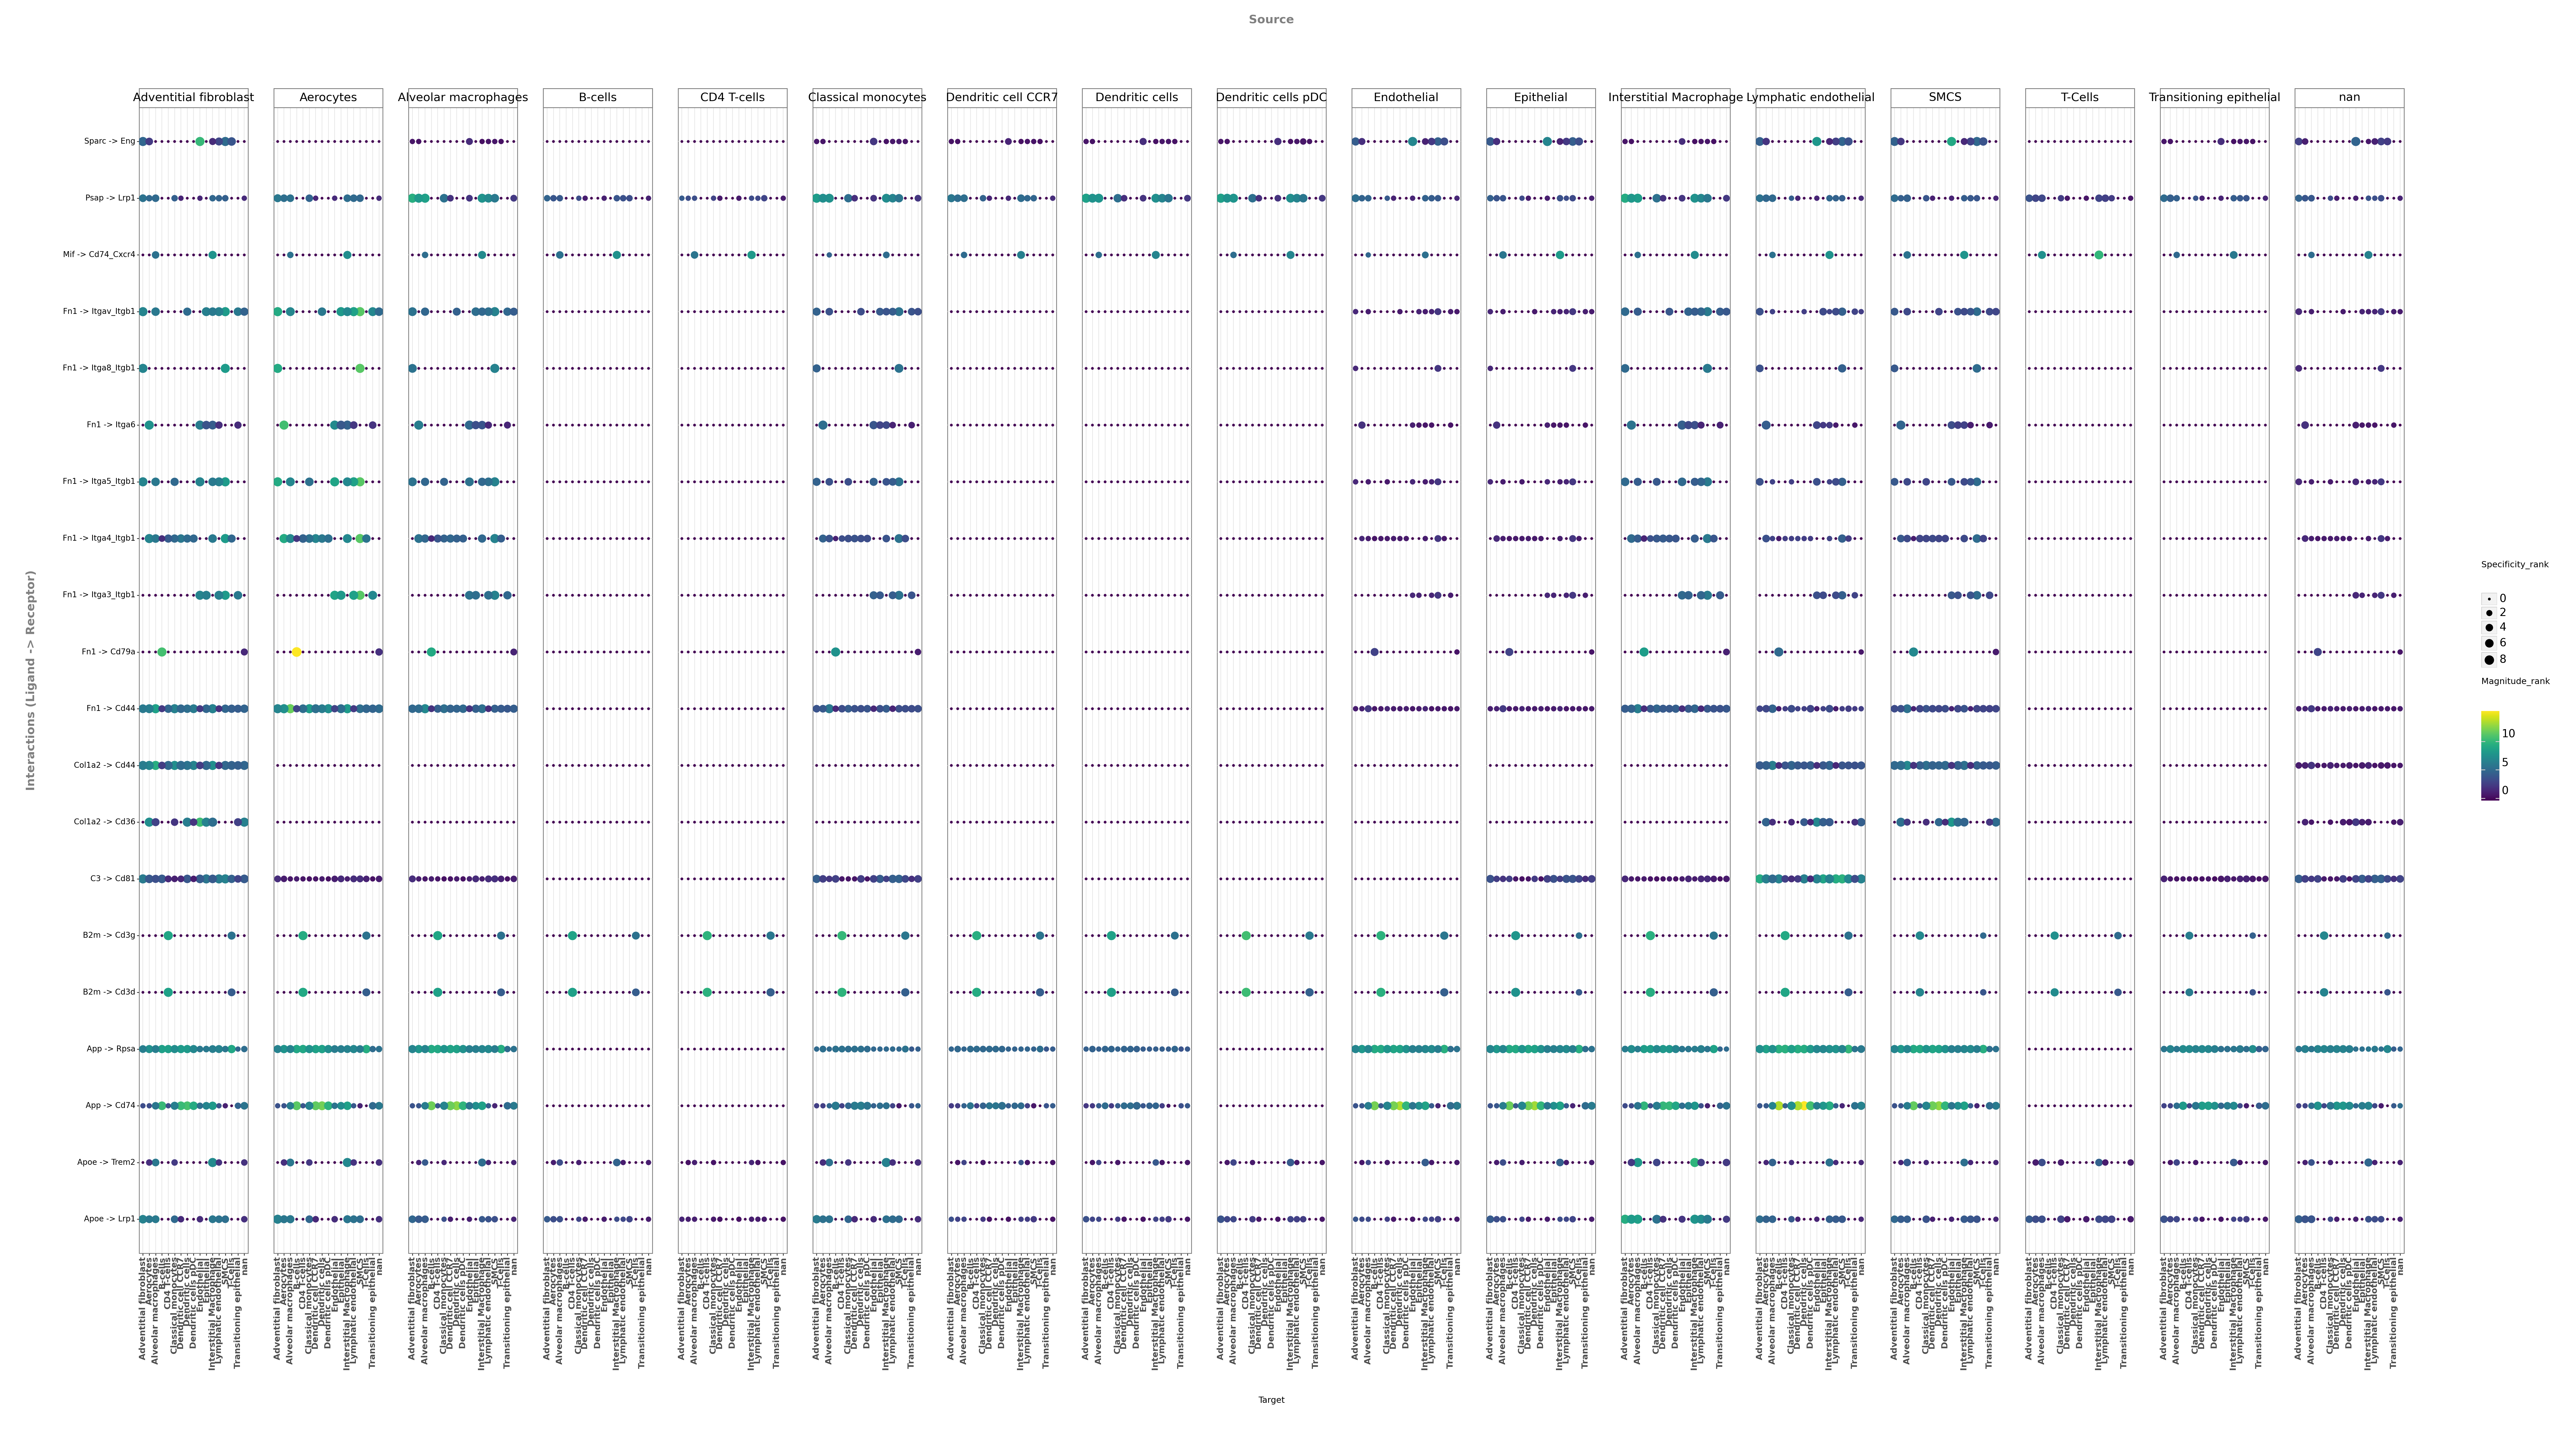

In [16]:
fig = li.pl.dotplot(
    adata=adata_cond,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(46, 26),
    size_range=(1, 6),
    return_fig=True
)   
#fig.save("./plots/"+file[:-5]+"_"+cond+"_liana.png", dpi=500, limitsize=False)
fig.draw()

In [17]:
type(adata_cond.uns["liana_res"])

pandas.core.frame.DataFrame

In [18]:
liana_res = adata_cond.uns["liana_res"].drop_duplicates(["ligand_complex", "receptor_complex"]).sort_values(["magnitude_rank", "specificity_rank"],)

In [19]:
%%R
# Increase timeout threshold
options(timeout=600)

# Load PK
ligand_target_matrix <- readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final_mouse.rds"))
lr_network <- readRDS(url("https://zenodo.org/record/7074291/files/lr_network_mouse_21122021.rds"))

In [20]:
sender_celltypes = ["Epithelial", "Fibroblasts", "Interstitial_macrophages"]
receiver_celltypes = ["Epithelial", "Fibroblasts", "Interstitial_macrophages"]

In [21]:
# Helper function to obtain sufficiently expressed genes
from functools import reduce


def get_expressed_genes(adata, cell_type, expr_prop):
    # calculate proportions
    temp = adata[adata.obs["manual_celltype_annotation"] == cell_type, :]
    a = temp.X.getnnz(axis=0) / temp.X.shape[0]
    stats = (
        pd.DataFrame({"genes": temp.var_names, "props": a})
        .assign(cell_type=cell_type)
        .sort_values("genes")
    )

    # obtain expressed genes
    stats = stats[stats["props"] >= expr_prop]
    expressed_genes = stats["genes"].values

    return expressed_genes

In [22]:
adata_cond[adata_cond.obs["manual_celltype_annotation"] == "Interstitial_macrophages", :]

View of AnnData object with n_obs × n_vars = 0 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'log1p', 'liana_res'
    layers: 'counts'

In [23]:
sender_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
        for cell_type in sender_celltypes
    ],
)
receiver_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
        for cell_type in receiver_celltypes
    ],
)

/tmp/user/21175/ipykernel_1126209/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_1126209/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_1126209/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_1126209/982473700.py:8: RuntimeWarning: invalid value encountered in divide


In [24]:
liana_res

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
11805,Aerocytes,B-cells,Fn1,Cd79a,3.182969,0.0,9.851899,3.147797,3.502686,0.274362,0.968785,0.223944,0.0,2.656876e-09,9.038300e-16
22578,Lymphatic endothelial,Dendritic cells,App,Cd74,3.221438,0.0,7.133852,1.283277,1.495362,0.019607,0.963516,0.174935,0.0,4.743963e-08,1.012236e-15
8288,Aerocytes,Alveolar macrophages,Fn1,Cd44,2.719403,0.0,6.410803,2.099922,2.415545,0.067627,0.961591,0.159716,0.0,4.743963e-08,2.755332e-12
45312,Aerocytes,SMCS,Fn1,Itga8_Itgb1,2.628603,0.0,5.736786,2.113131,2.255137,0.051330,0.959486,0.141278,0.0,4.743963e-08,8.982072e-12
45310,Aerocytes,SMCS,Fn1,Itga4_Itgb1,2.628603,0.0,5.736786,2.113131,2.255137,0.051330,0.959486,0.141278,0.0,4.743963e-08,8.982072e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62754,Adventitial fibroblast,Adventitial fibroblast,Tph1,Htr7,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000053,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
62782,Adventitial fibroblast,Adventitial fibroblast,Ceacam16,Tectb,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000053,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
62728,Adventitial fibroblast,Adventitial fibroblast,Rbp4,Stra6,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000053,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
62586,Adventitial fibroblast,Adventitial fibroblast,Qrfp,P2ry14,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000053,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00


In [25]:
liana_res.drop_duplicates(["source", "target"])

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
11805,Aerocytes,B-cells,Fn1,Cd79a,3.182969,0.000,9.851899,3.147797,3.502686,0.274362,0.968785,0.223944,0.0,2.656876e-09,9.038300e-16
22578,Lymphatic endothelial,Dendritic cells,App,Cd74,3.221438,0.000,7.133852,1.283277,1.495362,0.019607,0.963516,0.174935,0.0,4.743963e-08,1.012236e-15
8288,Aerocytes,Alveolar macrophages,Fn1,Cd44,2.719403,0.000,6.410803,2.099922,2.415545,0.067627,0.961591,0.159716,0.0,4.743963e-08,2.755332e-12
45312,Aerocytes,SMCS,Fn1,Itga8_Itgb1,2.628603,0.000,5.736786,2.113131,2.255137,0.051330,0.959486,0.141278,0.0,4.743963e-08,8.982072e-12
13880,Dendritic cells pDC,CD4 T-cells,B2m,Cd3g,2.506362,0.000,5.487245,1.523377,1.673850,0.052495,0.958613,0.146707,0.0,4.743963e-08,3.711096e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21207,Alveolar macrophages,Dendritic cells,Clec1b,Klrb1b,0.201368,0.000,0.024033,1.024216,0.316485,0.173894,0.605189,0.000000,1.0,1.376652e-05,1.573114e-01
20032,SMCS,Dendritic cell CCR7,Ntf3,Ngfr,0.186697,0.000,0.023525,2.508212,0.371555,0.502945,0.602637,0.000000,1.0,9.353069e-06,1.590997e-01
40473,B-cells,Lymphatic endothelial,Il16,Grin2c,0.218296,0.000,0.022902,1.228270,0.337746,0.178197,0.599418,0.000000,1.0,1.116271e-05,1.614842e-01
20180,T-Cells,Dendritic cell CCR7,Tnf,Ffar2,0.116570,0.024,0.012210,0.587291,0.179567,0.056540,0.522120,0.000000,1.0,2.507714e-04,2.140466e-01


In [26]:
top_res = liana_res.drop_duplicates(["source", "target"])[:20]

In [27]:
list(top_res.source)

['Aerocytes',
 'Lymphatic endothelial',
 'Aerocytes',
 'Aerocytes',
 'Dendritic cells pDC',
 'Aerocytes',
 'Adventitial fibroblast',
 'Lymphatic endothelial',
 'T-Cells',
 'Interstitial Macrophage',
 'Lymphatic endothelial',
 'Adventitial fibroblast',
 'Alveolar macrophages',
 'Interstitial Macrophage',
 'SMCS',
 'Transitioning epithelial',
 'Aerocytes',
 'Interstitial Macrophage',
 'Adventitial fibroblast',
 'Dendritic cells']

In [28]:
sources = list(top_res.source)
targets = list(top_res.target)

In [29]:
len(sources)

20

In [42]:
pdata.obs["manual_celltype_annotation"] = pdata.obs.manual_celltype_annotation.astype("category")

In [43]:
pdata.obs["manual_celltype_annotation"].cat.categories

Index(['Adventitial fibroblast', 'Aerocytes', 'Alveolar macrophages',
       'B-cells', 'CD4 T-cells', 'Classical monocytes', 'Dendritic cell CCR7',
       'Dendritic cells', 'Dendritic cells pDC', 'Endothelial', 'Epithelial',
       'Interstitial Macrophage', 'Lymphatic endothelial', 'Neutrophils',
       'SMCS', 'T-Cells', 'Transitioning epithelial', 'nan'],
      dtype='object')

In [44]:
for i in range (20):
    if (sources[i] in pdata.obs["manual_celltype_annotation"].cat.categories) and (targets[i] in pdata.obs["manual_celltype_annotation"].cat.categories):
        sender_celltypes = sources[i]
        receiver_celltypes = targets[i]
        print(sender_celltypes, receiver_celltypes)
    else:
        continue

Aerocytes B-cells
Lymphatic endothelial Dendritic cells
Aerocytes Alveolar macrophages
Aerocytes SMCS
Dendritic cells pDC CD4 T-cells
Aerocytes Aerocytes
Adventitial fibroblast Endothelial
Lymphatic endothelial T-Cells
T-Cells Interstitial Macrophage
Interstitial Macrophage Interstitial Macrophage
Lymphatic endothelial SMCS
Adventitial fibroblast Alveolar macrophages
Alveolar macrophages Adventitial fibroblast
Interstitial Macrophage Adventitial fibroblast
SMCS SMCS
Transitioning epithelial Epithelial
Aerocytes Epithelial
Interstitial Macrophage Endothelial
Adventitial fibroblast SMCS
Dendritic cells Dendritic cells pDC


In [48]:
sender_celltypes = sources.copy()
receiver_celltypes = targets.copy()

In [49]:
# create baseline and DEG with decoupler
sender_expressed = reduce(
        np.union1d,
        [
            get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
            for cell_type in sender_celltypes
        ],
    )
receiver_expressed = reduce(
        np.union1d,
        [
            get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
            for cell_type in receiver_celltypes
        ],
    )

print(f"running NicheNet on {sender_celltypes} - {receiver_celltypes} pair")
robjects.globalenv['sender_expressed'] = sender_expressed
robjects.globalenv['receiver_expressed'] = receiver_expressed
robjects.r('''
    # get ligands and receptors in the resource
    ligands <- lr_network %>% pull(from) %>% unique()
    receptors <- lr_network %>% pull(to) %>% unique()

    # only keep the intersect between the resource and the data
    expressed_ligands <- intersect(ligands, sender_expressed)
    expressed_receptors <- intersect(receptors, receiver_expressed)

    # filter the network to only include ligands for which both the ligand and receptor are expressed
    potential_ligands <- lr_network %>% 
    filter(from %in% expressed_ligands & to %in% expressed_receptors) %>%
    pull(from) %>% unique()
''')

# only keep the receiver cell type(s)
deg = deg[np.isin(deg["contrast"], receiver_celltypes)]
# define background of sufficiently expressed genes
background_genes = deg["name"].values

# only keep significant and positive DE genes
deg = deg[(deg["pvals"] <= 0.05) & (deg["logFCs"] > 1)]
# get geneset of interest
geneset_oi = deg["name"].values

print("getting ligand activities")
robjects.globalenv['geneset_oi'] = geneset_oi
robjects.globalenv['background_genes'] = background_genes
robjects.r('''
    ligand_activities <- predict_ligand_activities(geneset = geneset_oi, 
                                                background_expressed_genes = background_genes,
                                                ligand_target_matrix = ligand_target_matrix,
                                                potential_ligands = potential_ligands)

    ligand_activities <- ligand_activities %>% 
    arrange(-aupr) %>% 
    mutate(rank = rank(desc(aupr)))
            ''')
ligand_activities = robjects.r["ligand_activities"]
robjects.globalenv['ligand_activities'] = ligand_activities

robjects.r('''
    top_ligands <- ligand_activities %>%
    top_n(15, aupr) %>% 
    arrange(-aupr) %>%
    pull(test_ligand) %>%
    unique()

    # get regulatory potentials
    ligand_target_potential <- map(top_ligands,
                                ~get_weighted_ligand_target_links(.x,
                                                                    geneset = geneset_oi,
                                                                    ligand_target_matrix = ligand_target_matrix,
                                                                    n = 500)
                                ) %>%
        bind_rows() %>% 
        drop_na()
        
    # prep for visualization
    active_ligand_target_links <- 
    prepare_ligand_target_visualization(ligand_target_df = ligand_target_potential, 
                                        ligand_target_matrix = ligand_target_matrix)

    # order ligands & targets
    order_ligands <- intersect(top_ligands,
                            colnames(active_ligand_target_links)) %>% rev() %>% make.names()
    order_targets <- ligand_target_potential$target %>%
    unique() %>% 
    intersect(rownames(active_ligand_target_links)) %>%
    make.names()
    rownames(active_ligand_target_links) <- rownames(active_ligand_target_links) %>%
    make.names() # make.names() for heatmap visualization of genes like H2-T23
    colnames(active_ligand_target_links) <- colnames(active_ligand_target_links) %>%
    make.names() # make.names() for heatmap visualization of genes like H2-T23

    vis_ligand_target <- active_ligand_target_links[order_targets, order_ligands] %>%
    t()
        
    # convert to dataframe, and then it's returned to py
    vis_ligand_target <- vis_ligand_target %>%
        as.data.frame() %>%
        rownames_to_column("ligand") %>%
        as_tibble()
''')
vis_ligand_target = robjects.r["vis_ligand_target"]

# convert dot to underscore and set ligand as index
vis_ligand_target["ligand"] = vis_ligand_target["ligand"].replace("\.", "_", regex=True)
vis_ligand_target.set_index("ligand", inplace=True)
# keep only columns where at least one gene has a regulatory potential >= 0.05
vis_ligand_target = vis_ligand_target.loc[
    :, vis_ligand_target[vis_ligand_target >= 0.05].any()
]


R[write to console]: Error in evaluate_target_prediction(setting, ligand_target_matrix, ligands_position) : 
  setting$response should be named logical vector containing class labels of the response that needs to be predicted 



running NicheNet on ['Aerocytes', 'Lymphatic endothelial', 'Aerocytes', 'Aerocytes', 'Dendritic cells pDC', 'Aerocytes', 'Adventitial fibroblast', 'Lymphatic endothelial', 'T-Cells', 'Interstitial Macrophage', 'Lymphatic endothelial', 'Adventitial fibroblast', 'Alveolar macrophages', 'Interstitial Macrophage', 'SMCS', 'Transitioning epithelial', 'Aerocytes', 'Interstitial Macrophage', 'Adventitial fibroblast', 'Dendritic cells'] - ['B-cells', 'Dendritic cells', 'Alveolar macrophages', 'SMCS', 'CD4 T-cells', 'Aerocytes', 'Endothelial', 'T-Cells', 'Interstitial Macrophage', 'Interstitial Macrophage', 'SMCS', 'Alveolar macrophages', 'Adventitial fibroblast', 'Adventitial fibroblast', 'SMCS', 'Epithelial', 'Epithelial', 'Endothelial', 'SMCS', 'Dendritic cells pDC'] pair
getting ligand activities


RRuntimeError: Error in evaluate_target_prediction(setting, ligand_target_matrix, ligands_position) : 
  setting$response should be named logical vector containing class labels of the response that needs to be predicted 


NameError: name 'vis_ligand_target' is not defined

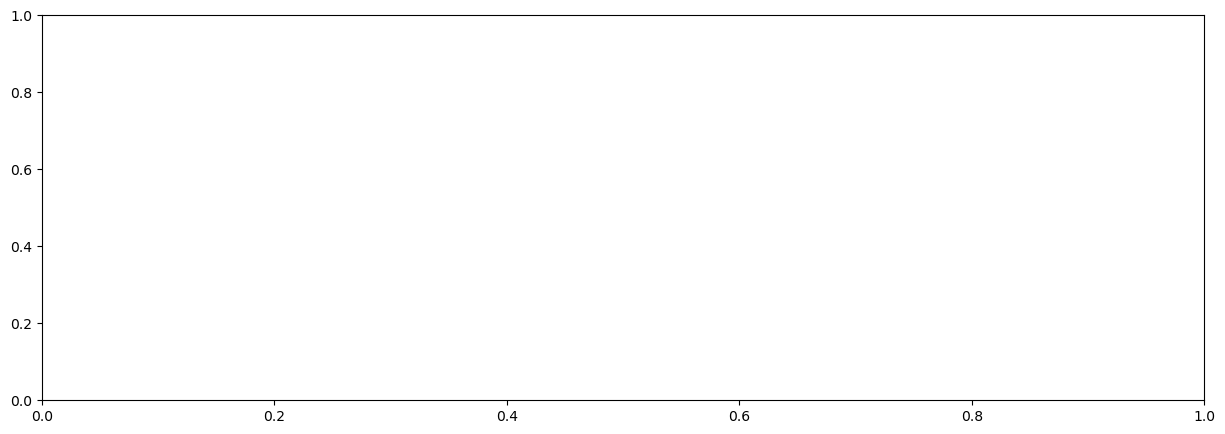

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(vis_ligand_target, xticklabels=True, ax=ax)
plt.show()